# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

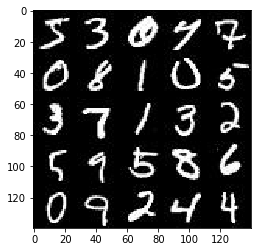

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

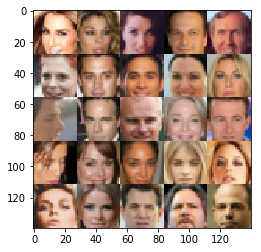

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate ## confused here...instructions leave LR out and it's causing problems in training


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.contrib.layers.conv2d(images, 64, 5, 2) # 14x14x64
        conv_1 = tf.nn.relu(conv_1)
        
        conv_2 = tf.contrib.layers.conv2d(conv_1, 128, 5, 2) # 7x7x128
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        conv_2 = tf.nn.relu(conv_2)
        
        conv_3 = tf.contrib.layers.conv2d(conv_2, 256, 5, 2) # 4x4x256
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        conv_3 = tf.nn.relu(conv_3)

        flatten = tf.reshape(conv_3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*1024)
        x = tf.reshape(x, (-1, 7, 7, 1024))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.relu(x)
        # 7x7x1024
        
        conv_1 = tf.layers.conv2d_transpose(x, 512, 5, strides=2, padding='same') #14x14x512
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        conv_1 = tf.nn.relu(conv_1)
        
        conv_2 = tf.layers.conv2d_transpose(conv_1, 256, 5, strides=2, padding='same') #28x28x256
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        conv_2 = tf.nn.relu(conv_2)
        
        conv_3 = tf.layers.conv2d_transpose(conv_2, 128, 5, strides=1, padding='same') #28x28x128
        conv_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        conv_3 = tf.nn.relu(conv_2)
        
        logits = tf.layers.conv2d_transpose(conv_3, out_channel_dim, 5, strides=1, padding='same') #28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

SyntaxError: invalid syntax (<ipython-input-13-3e026cdb60c9>, line 25)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g = generator(input_z, out_channel_dim)
    d_real, d_logits_real = discriminator(input_real)
    d_fake, d_logits_fake = discriminator(g, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, _lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                
                if steps % 100 == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 6.6572
Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 8.0137
Epoch 1/2... Discriminator Loss: 0.3448... Generator Loss: 5.3833
Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 6.2892
Epoch 1/2... Discriminator Loss: 0.3362... Generator Loss: 6.4129
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 7.1088
Epoch 1/2... Discriminator Loss: 0.3346... Generator Loss: 6.8172
Epoch 1/2... Discriminator Loss: 0.3302... Generator Loss: 7.8626
Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 7.4814
Epoch 1/2... Discriminator Loss: 0.3379... Generator Loss: 5.5160


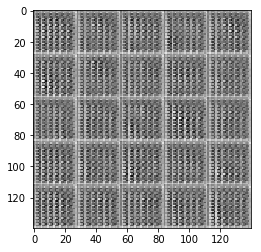

Epoch 1/2... Discriminator Loss: 0.3555... Generator Loss: 4.5149
Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 3.6447
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 2.7541
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 4.3754
Epoch 1/2... Discriminator Loss: 0.4860... Generator Loss: 2.7028
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 3.1030
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.7009
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 1.8990
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.2955


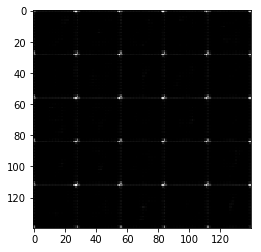

Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.9729
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.9225
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.2725
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.9055
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 1.2413
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.5806
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 2.2966
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.6594


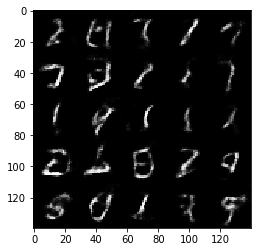

Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.2982
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 1.1136
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 0.9394... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.7607


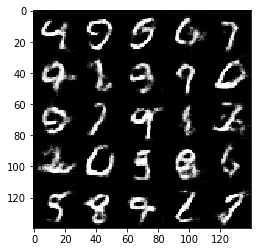

Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 2.0086
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.4400
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 2.1213
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.9776
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 1.5193... Generator Loss: 0.4939


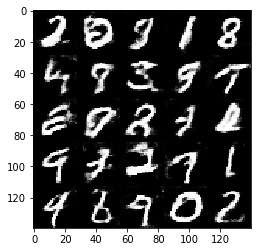

Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 1.1715
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.2140
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 1.0965


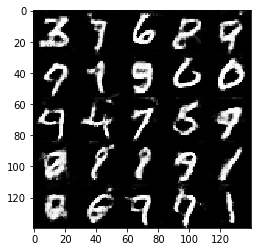

Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.6126
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.7920
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.8634


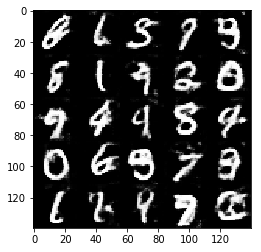

Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 1.0909
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 1.5241
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.2517... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 0.8829


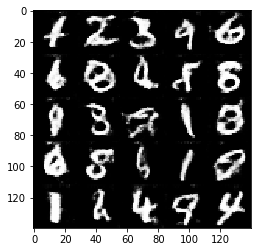

Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 1.3639
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.7732
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 1.5554
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.2551


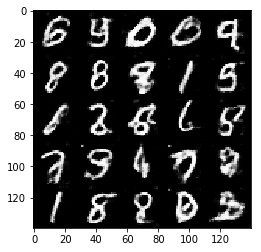

Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.7944


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 4.2896
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.6836
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.5127
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 5.6553
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 9.9169
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 4.0135
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 7.4874
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 5.4851
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 5.7889
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 5.2534


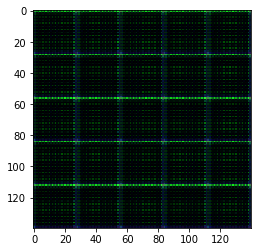

Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 5.0965
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 8.1043
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 5.2123
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 4.7613
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 5.5091
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 7.4970
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 4.0158
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 3.0374
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 2.6056
Epoch 1/1... Discriminator Loss: 1.9553... Generator Loss: 8.9376


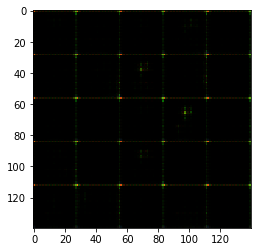

Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.9266
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 4.4320
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 4.0109
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 4.7513
Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.6315
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.8395
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 5.1956
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 8.4377
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 5.2114
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 4.0918


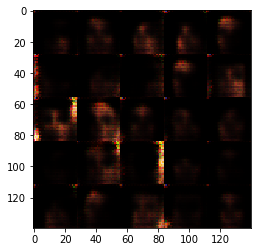

Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 7.6531
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.7477
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 2.5151
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.0700


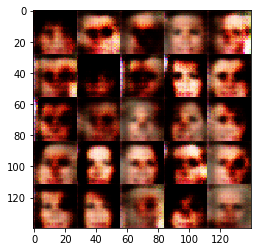

Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 4.2171
Epoch 1/1... Discriminator Loss: 1.6929... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 4.4049
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.6072


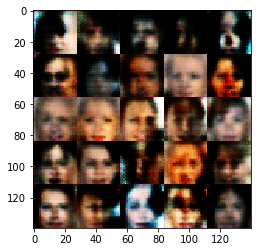

Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 4.9520
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 4.0600
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6536


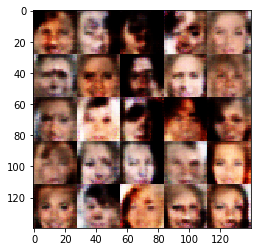

Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 4.5113
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.8618... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.2799


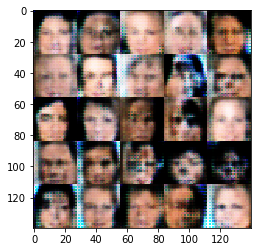

Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4566


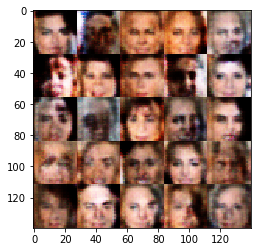

Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 2.0677
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 6.6130
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.4516


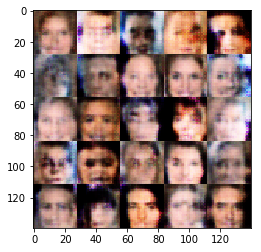

Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 6.5349
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.8084
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.4624
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 4.8811
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 2.0817


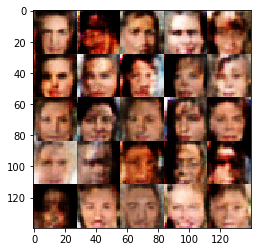

Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 4.1270
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.8616
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 2.7049
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.2052


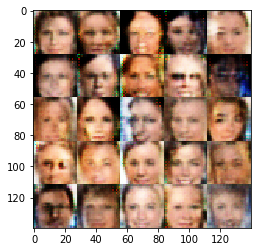

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.8598
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 2.2870
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 2.9695
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.3837


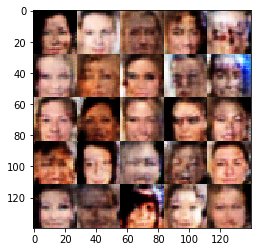

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.8722... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 2.0802
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.4369
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 4.9166
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.3329


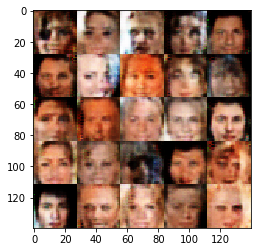

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 2.3655... Generator Loss: 0.1810
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 2.0013
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 5.9862
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 2.0819
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5075


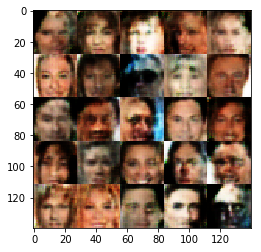

Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 2.8102
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 4.9468
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 2.9951
Epoch 1/1... Discriminator Loss: 2.1681... Generator Loss: 0.1937


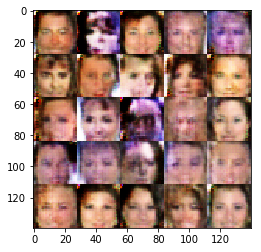

Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 2.2025
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.9057
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.2842
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.6652


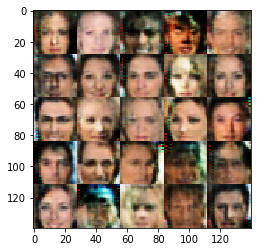

Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.8563
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.2001


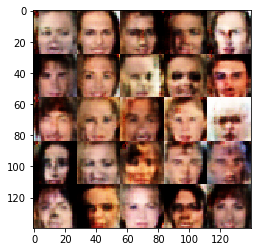

Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 4.2740
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 0.2581
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.4139
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.7085... Generator Loss: 0.3464
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8182


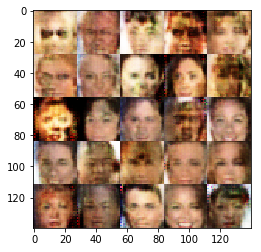

Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 4.8948
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 2.0820... Generator Loss: 0.2228
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 2.2058... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 5.3916


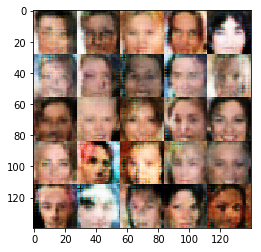

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.6587
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 3.3062


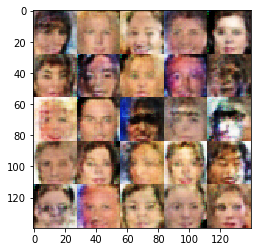

Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 5.9542
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5526


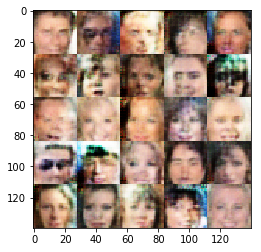

Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 4.4977
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 6.5227
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 4.0001
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.9186... Generator Loss: 0.2818
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5000


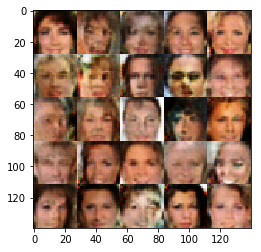

Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7109


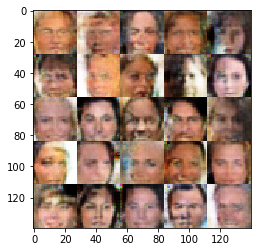

Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 2.0577
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 5.1074
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.8129


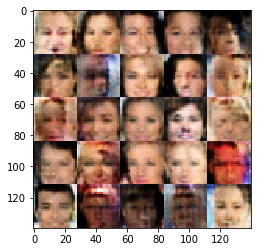

Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 2.3125
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.4006


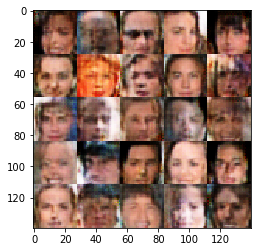

Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 3.9680
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 2.0229... Generator Loss: 0.2707


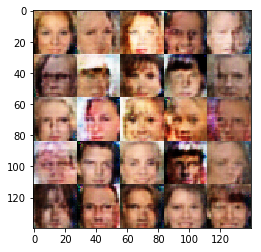

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 2.3978


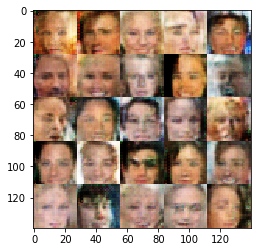

Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.7847... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.9842


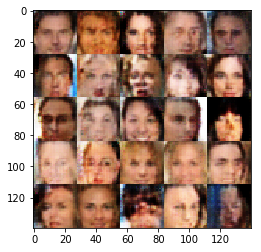

Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 4.9719
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.5776


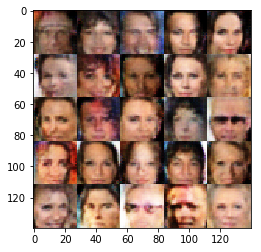

Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 2.0016... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 4.1080
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.4093


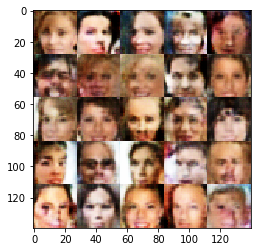

Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 0.3424
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 4.1602
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1217


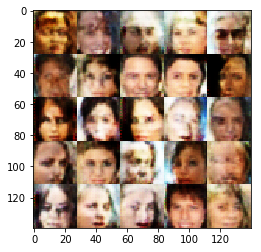

Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.9039... Generator Loss: 0.3138


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.